In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_22_34_05
NN-MODEL FILENAME:  ./models/VBKG0BIX_22_34_05_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.intp)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax().astype(np.intp)
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.intp)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 64
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1254.21 MiB, increment: 1034.29 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15558
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 61
TOTAL SERIAL TIMESTEPS:   15558
TOTAL PARALLEL TIMESTEPS: 61


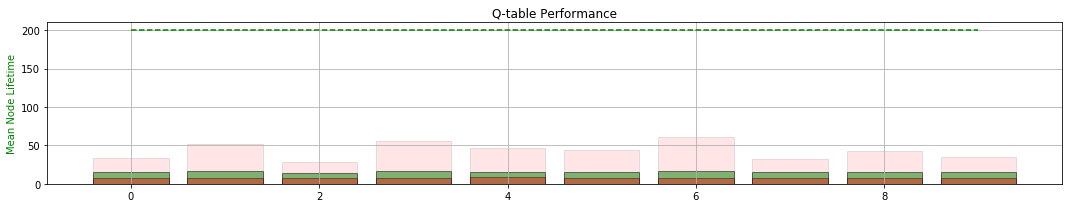

MEMORY COUNTER:  15558
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 532.195	LOSS : 494.115	LOSS : 479.855	LOSS : 465.387	LOSS : 444.206	LOSS : 448.230	LOSS : 435.132	LOSS : 412.985	LOSS : 409.342	LOSS : 391.902	LOSS : 390.943	LOSS : 382.069	LOSS : 383.766	LOSS : 382.108	LOSS : 375.207	LOSS : 373.009	LOSS : 377.306	LOSS : 368.477	LOSS : 368.523	LOSS : 368.470	
Validating... MEAN TIME:  139.395
LOSS : 359.772	LOSS : 363.986	LOSS : 365.994	LOSS : 353.738	LOSS : 354.232	LOSS : 367.849	LOSS : 360.140	LOSS : 370.619	LOSS : 364.211	LOSS : 365.005	LOSS : 374.214	LOSS : 381.391	LOSS : 387.035	LOSS : 388.956	LOSS : 387.513	LOSS : 387.003	LOSS : 397.571	LOSS : 394.379	LOSS : 397.825	LOSS : 399.395	
Validating... MEAN TIME:  150.82
LOSS : 406.140	LOSS : 421.501	LOSS : 415.405	LOSS : 427.330	LOSS : 423.725	LOSS : 440.922	LOSS : 442.885	LOSS : 447.023	LOSS : 446.844	LOSS : 445.196	LOSS : 466.398	LOSS : 464.698	LOSS : 471.368	LOSS : 472.475	LOSS : 484.861	LOSS : 489.179	LOSS : 49

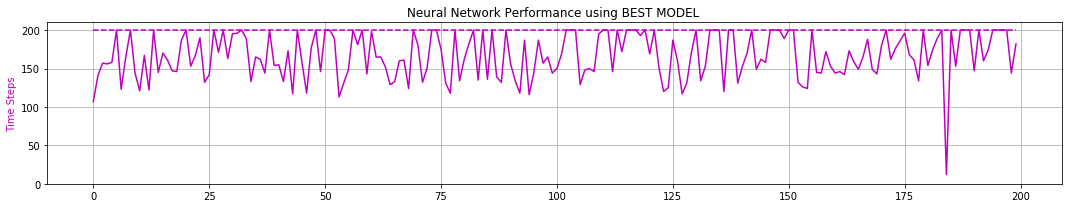

peak memory: 1299.70 MiB, increment: 1012.88 MiB
0 -max- [ 0.338  2.159  0.206  1.734]
0 -min- [-0.154 -1.207 -0.209 -2.916]

1 -max- [ 0.364  1.986  0.203  1.216]
1 -min- [-0.126 -0.943 -0.209 -2.766]

2 -max- [ 0.249  1.803  0.204  1.669]
2 -min- [-0.173 -1.027 -0.209 -2.749]

3 -max- [ 0.910  3.634  0.207  2.169]
3 -min- [-0.185 -1.331 -0.209 -3.350]

4 -max- [ 0.590  2.667  0.207  1.767]
4 -min- [-0.108 -0.981 -0.209 -2.742]

5 -max- [ 0.355  2.262  0.207  1.775]
5 -min- [-0.162 -1.120 -0.209 -2.747]

6 -max- [ 0.756  2.327  0.201  1.385]
6 -min- [-0.126 -0.976 -0.209 -3.012]

7 -max- [ 0.258  2.080  0.206  1.026]
7 -min- [-0.058 -0.627 -0.209 -2.751]

8 -max- [ 0.216  1.797  0.196  1.515]
8 -min- [-0.297 -1.496 -0.209 -2.726]

9 -max- [ 0.272  2.465  0.195  2.014]
9 -min- [-0.163 -1.167 -0.208 -2.961]

Quantization TIME:  0.01 minutes


ITERATION # 1
TOTAL EXPERIENCE GENERATED:   53607
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   69165
TOTAL PARALLEL TIMES

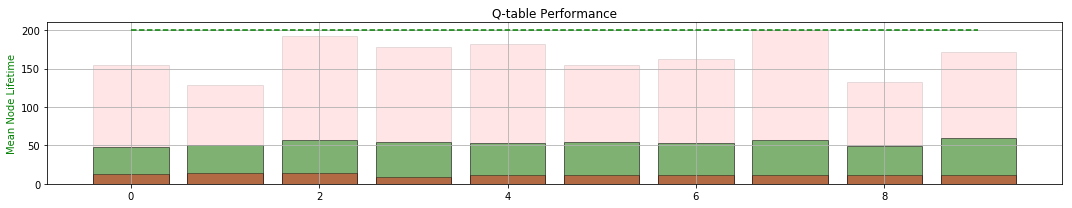

MEMORY COUNTER:  69165
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 667.076	LOSS : 607.394	LOSS : 560.234	LOSS : 523.387	LOSS : 485.559	LOSS : 460.919	LOSS : 436.392	LOSS : 400.763	LOSS : 395.137	LOSS : 392.188	LOSS : 376.872	LOSS : 371.656	LOSS : 375.050	LOSS : 349.625	LOSS : 345.900	LOSS : 347.166	LOSS : 356.255	LOSS : 359.795	LOSS : 340.660	LOSS : 343.918	
Validating... MEAN TIME:  108.68
LOSS : 333.755	LOSS : 335.464	LOSS : 332.642	LOSS : 330.112	LOSS : 339.107	LOSS : 334.217	LOSS : 326.347	LOSS : 336.716	LOSS : 351.788	LOSS : 334.562	LOSS : 332.222	LOSS : 320.544	LOSS : 321.154	LOSS : 331.939	LOSS : 334.568	LOSS : 343.374	LOSS : 314.189	LOSS : 342.776	LOSS : 327.124	LOSS : 337.412	
Validating... MEAN TIME:  106.685
LOSS : 315.775	LOSS : 310.228	LOSS : 325.021	LOSS : 323.316	LOSS : 320.547	LOSS : 319.946	LOSS : 327.728	LOSS : 327.716	LOSS : 338.603	LOSS : 323.301	LOSS : 337.496	LOSS : 344.192	LOSS : 336.263	LOSS : 328.605	LOSS : 323.341	LOSS : 339.881	LOSS : 34

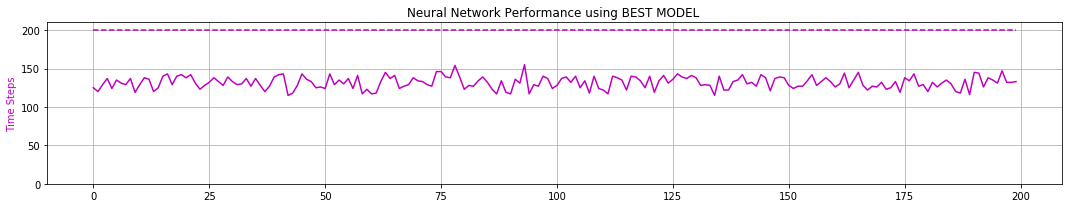

peak memory: 1400.73 MiB, increment: 1051.54 MiB
0 -max- [ 0.547  1.501  0.209  2.966]
0 -min- [-0.962 -2.337 -0.209 -2.347]

1 -max- [ 1.109  1.841  0.209  2.839]
1 -min- [-0.769 -2.475 -0.209 -1.976]

2 -max- [ 1.168  1.725  0.209  3.202]
2 -min- [-0.883 -2.861 -0.209 -2.141]

3 -max- [ 1.193  1.908  0.209  3.402]
3 -min- [-1.215 -2.698 -0.209 -2.621]

4 -max- [ 1.163  1.771  0.209  3.233]
4 -min- [-0.890 -2.685 -0.209 -2.349]

5 -max- [ 1.130  1.635  0.209  2.990]
5 -min- [-1.180 -2.703 -0.209 -2.120]

6 -max- [ 1.327  1.872  0.209  3.082]
6 -min- [-0.902 -2.645 -0.209 -2.419]

7 -max- [ 1.137  1.947  0.209  2.893]
7 -min- [-0.957 -2.514 -0.209 -2.263]

8 -max- [ 1.277  2.083  0.209  2.928]
8 -min- [-0.668 -2.525 -0.209 -2.191]

9 -max- [ 1.236  1.889  0.209  2.634]
9 -min- [-1.025 -2.450 -0.209 -2.195]

Quantization TIME:  0.01 minutes


ITERATION # 2
TOTAL EXPERIENCE GENERATED:   80821
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 123
TOTAL SERIAL TIMESTEPS:   149986
TOTAL PARALLEL TIME

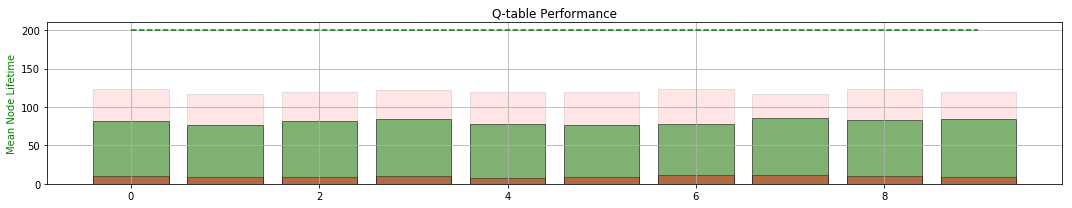

MEMORY COUNTER:  149986
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 341.060	LOSS : 339.942	LOSS : 306.000	LOSS : 324.315	LOSS : 306.406	LOSS : 320.363	LOSS : 321.218	LOSS : 301.472	LOSS : 287.341	LOSS : 298.741	LOSS : 280.376	LOSS : 293.007	LOSS : 300.712	LOSS : 285.291	LOSS : 280.067	LOSS : 282.024	LOSS : 283.418	LOSS : 299.445	LOSS : 294.398	LOSS : 305.184	
Validating... MEAN TIME:  138.285
LOSS : 303.903	LOSS : 302.453	LOSS : 311.167	LOSS : 307.526	LOSS : 304.713	LOSS : 297.511	LOSS : 298.183	LOSS : 310.427	LOSS : 311.337	LOSS : 306.153	LOSS : 300.314	LOSS : 323.087	LOSS : 332.747	LOSS : 321.295	LOSS : 311.026	LOSS : 301.713	LOSS : 322.360	LOSS : 322.358	LOSS : 327.564	LOSS : 324.570	
Validating... MEAN TIME:  171.18
LOSS : 341.706	LOSS : 315.665	LOSS : 316.688	LOSS : 318.237	LOSS : 316.309	LOSS : 324.520	LOSS : 347.034	LOSS : 341.436	LOSS : 323.845	LOSS : 311.973	LOSS : 338.310	LOSS : 335.065	LOSS : 336.590	LOSS : 329.829	LOSS : 340.549	LOSS : 329.538	LOSS : 3

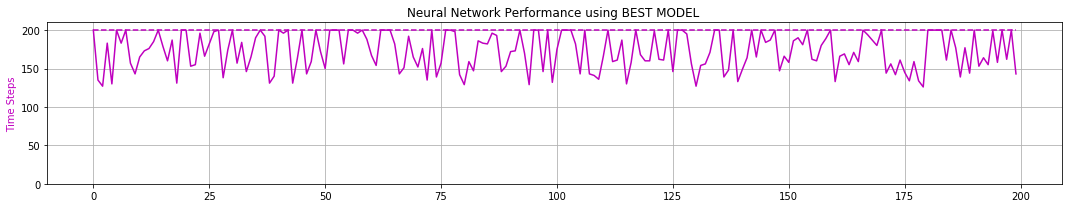

peak memory: 1411.93 MiB, increment: 1017.81 MiB
0 -max- [ 0.206  1.203  0.155  1.452]
0 -min- [-2.399 -3.171 -0.209 -2.253]

1 -max- [ 0.203  1.179  0.050  1.201]
1 -min- [-2.400 -3.090 -0.209 -1.681]

2 -max- [ 0.185  1.166  0.047  1.239]
2 -min- [-2.400 -3.178 -0.209 -1.866]

3 -max- [ 0.218  1.212  0.048  1.418]
3 -min- [-2.400 -3.097 -0.209 -1.938]

4 -max- [ 0.214  1.217  0.049  1.257]
4 -min- [-2.399 -3.113 -0.209 -1.954]

5 -max- [ 0.213  1.365  0.059  1.156]
5 -min- [-2.397 -3.334 -0.209 -1.961]

6 -max- [ 0.212  1.390  0.050  1.213]
6 -min- [-2.400 -2.981 -0.209 -2.040]

7 -max- [ 0.214  1.309  0.104  1.223]
7 -min- [-2.399 -2.979 -0.209 -1.750]

8 -max- [ 0.197  1.163  0.049  1.316]
8 -min- [-2.399 -3.114 -0.209 -1.770]

9 -max- [ 0.239  1.192  0.060  1.386]
9 -min- [-2.400 -2.952 -0.209 -1.857]

Quantization TIME:  0.01 minutes


ITERATION # 3
TOTAL EXPERIENCE GENERATED:   61744
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 107
TOTAL SERIAL TIMESTEPS:   211730
TOTAL PARALLEL TIM

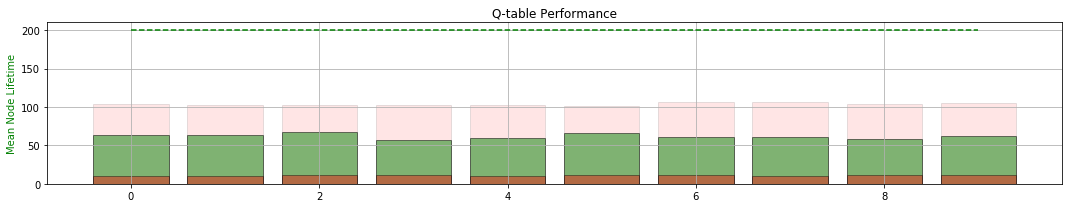

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 269.431	LOSS : 267.631	LOSS : 258.108	LOSS : 248.825	LOSS : 249.215	LOSS : 252.497	LOSS : 249.341	LOSS : 243.022	LOSS : 249.468	LOSS : 246.125	LOSS : 240.042	LOSS : 251.674	LOSS : 253.314	LOSS : 234.284	LOSS : 244.662	LOSS : 246.434	LOSS : 245.894	LOSS : 252.584	LOSS : 234.436	LOSS : 249.092	
Validating... MEAN TIME:  133.17
LOSS : 246.150	LOSS : 240.392	LOSS : 246.345	LOSS : 242.737	LOSS : 242.269	LOSS : 236.860	LOSS : 248.307	LOSS : 249.128	LOSS : 256.097	LOSS : 248.806	LOSS : 243.429	LOSS : 261.065	LOSS : 248.044	LOSS : 251.754	LOSS : 238.874	LOSS : 251.154	LOSS : 265.205	LOSS : 255.276	LOSS : 247.870	LOSS : 257.339	
Validating... MEAN TIME:  121.685
LOSS : 244.953	LOSS : 237.146	LOSS : 248.132	LOSS : 244.473	LOSS : 234.727	LOSS : 232.159	LOSS : 214.708	LOSS : 236.458	LOSS : 264.376	LOSS : 252.118	LOSS : 247.735	LOSS : 257.985	LOSS : 242.570	LOSS : 230.614	LOSS : 244.567	LOSS : 249.725	LOSS : 2

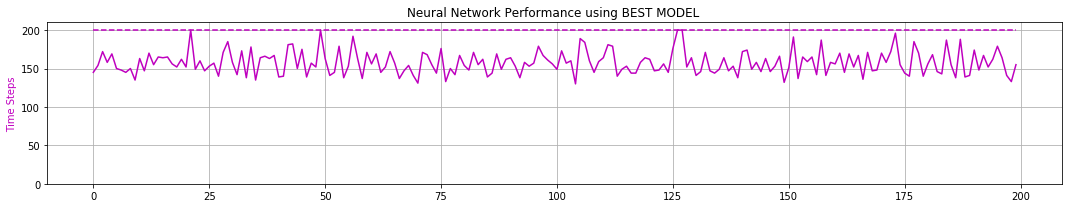

peak memory: 1393.23 MiB, increment: 998.66 MiB
0 -max- [ 0.203  1.179  0.050  1.248]
0 -min- [-1.448 -1.869 -0.209 -1.674]

1 -max- [ 0.208  1.201  0.047  1.125]
1 -min- [-1.425 -1.865 -0.209 -1.680]

2 -max- [ 0.233  1.196  0.048  1.236]
2 -min- [-1.407 -1.876 -0.209 -1.764]

3 -max- [ 0.214  1.174  0.048  0.987]
3 -min- [-1.391 -1.855 -0.209 -1.663]

4 -max- [ 0.213  1.208  0.046  1.434]
4 -min- [-1.455 -1.866 -0.209 -1.705]

5 -max- [ 0.205  1.180  0.048  0.997]
5 -min- [-1.415 -1.863 -0.209 -1.681]

6 -max- [ 0.205  1.199  0.049  0.992]
6 -min- [-1.426 -1.868 -0.209 -1.813]

7 -max- [ 0.201  1.204  0.049  1.011]
7 -min- [-1.417 -1.865 -0.209 -1.680]

8 -max- [ 0.223  1.130  0.049  0.998]
8 -min- [-1.392 -1.859 -0.209 -1.672]

9 -max- [ 0.212  1.216  0.050  1.186]
9 -min- [-1.379 -1.861 -0.209 -1.706]

Quantization TIME:  0.02 minutes


ITERATION # 4
TOTAL EXPERIENCE GENERATED:   130492
SMALLEST TIMESTEP: 85
LARGEST  TIMESTEP: 182
TOTAL SERIAL TIMESTEPS:   342222
TOTAL PARALLEL TIM

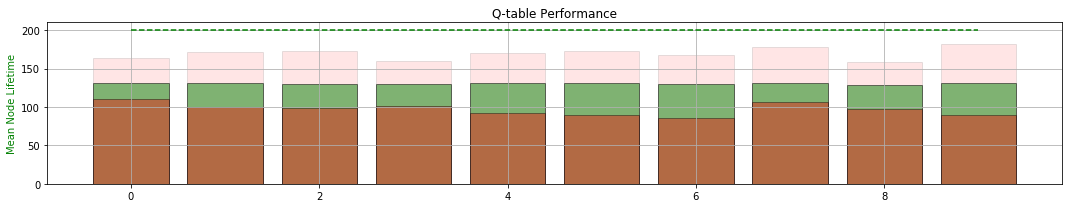

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 178.385	LOSS : 185.770	LOSS : 209.977	LOSS : 200.062	LOSS : 198.466	LOSS : 203.484	LOSS : 194.193	LOSS : 209.057	LOSS : 203.920	LOSS : 199.445	LOSS : 195.072	LOSS : 188.544	LOSS : 193.045	LOSS : 191.945	LOSS : 172.155	LOSS : 178.530	LOSS : 169.367	LOSS : 170.315	LOSS : 164.383	LOSS : 153.056	
Validating... MEAN TIME:  134.785
LOSS : 161.228	LOSS : 156.047	LOSS : 146.736	LOSS : 146.412	LOSS : 146.757	LOSS : 140.432	LOSS : 141.787	LOSS : 140.410	LOSS : 145.425	LOSS : 147.192	LOSS : 136.025	LOSS : 141.748	LOSS : 144.576	LOSS : 145.724	LOSS : 134.266	LOSS : 141.133	LOSS : 138.454	LOSS : 138.538	LOSS : 129.041	LOSS : 132.477	
Validating... MEAN TIME:  128.35
LOSS : 136.145	LOSS : 121.950	LOSS : 129.182	LOSS : 136.371	LOSS : 136.018	LOSS : 124.784	LOSS : 132.181	LOSS : 131.497	LOSS : 127.405	LOSS : 126.716	LOSS : 135.291	LOSS : 130.989	LOSS : 131.815	LOSS : 131.556	LOSS : 126.567	LOSS : 131.872	LOSS : 1

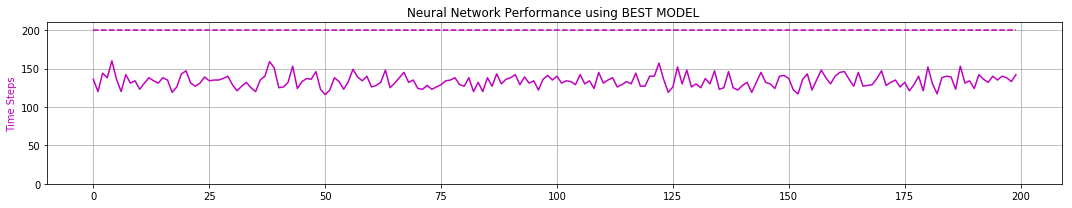

peak memory: 1417.27 MiB, increment: 979.01 MiB
0 -max- [ 0.113  0.825  0.047  0.692]
0 -min- [-2.399 -3.153 -0.209 -1.173]

1 -max- [ 0.144  1.006  0.053  0.709]
1 -min- [-2.400 -3.164 -0.209 -1.403]

2 -max- [ 0.116  0.978  0.048  0.727]
2 -min- [-2.399 -3.142 -0.208 -1.367]

3 -max- [ 0.141  1.019  0.046  0.766]
3 -min- [-2.399 -3.161 -0.209 -1.364]

4 -max- [ 0.106  0.973  0.048  0.707]
4 -min- [-2.400 -3.159 -0.209 -1.428]

5 -max- [ 0.119  0.829  0.049  0.736]
5 -min- [-2.400 -3.160 -0.209 -1.183]

6 -max- [ 0.111  0.989  0.049  0.691]
6 -min- [-2.400 -3.163 -0.209 -1.366]

7 -max- [ 0.122  0.828  0.049  0.820]
7 -min- [-2.399 -3.085 -0.209 -1.192]

8 -max- [ 0.125  1.003  0.050  0.834]
8 -min- [-2.399 -3.158 -0.209 -1.435]

9 -max- [ 0.134  0.828  0.048  0.691]
9 -min- [-2.399 -3.162 -0.209 -1.179]

Quantization TIME:  0.01 minutes


ITERATION # 5
TOTAL EXPERIENCE GENERATED:   95909
SMALLEST TIMESTEP: 12
LARGEST  TIMESTEP: 147
TOTAL SERIAL TIMESTEPS:   438131
TOTAL PARALLEL TIME

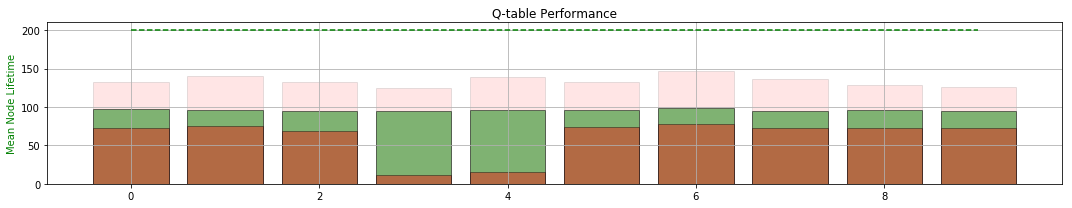

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 107.639	LOSS : 97.945	LOSS : 95.739	LOSS : 92.387	LOSS : 82.288	LOSS : 86.190	LOSS : 91.131	LOSS : 88.850	LOSS : 89.529	LOSS : 87.869	LOSS : 87.212	LOSS : 86.710	LOSS : 96.277	LOSS : 95.114	LOSS : 91.738	LOSS : 86.753	LOSS : 90.199	LOSS : 85.375	LOSS : 85.073	LOSS : 92.383	
Validating... MEAN TIME:  106.58
LOSS : 84.889	LOSS : 88.338	LOSS : 86.022	LOSS : 89.101	LOSS : 83.369	LOSS : 83.925	LOSS : 85.131	LOSS : 86.646	LOSS : 87.026	LOSS : 86.600	LOSS : 90.920	LOSS : 89.428	LOSS : 87.272	LOSS : 93.968	LOSS : 91.898	LOSS : 85.929	LOSS : 88.340	LOSS : 91.278	LOSS : 90.767	LOSS : 90.160	
Validating... MEAN TIME:  102.48
LOSS : 87.355	LOSS : 84.477	LOSS : 95.844	LOSS : 90.789	LOSS : 99.225	LOSS : 95.137	LOSS : 93.294	LOSS : 98.179	LOSS : 77.415	LOSS : 98.594	LOSS : 97.851	LOSS : 97.373	LOSS : 100.180	LOSS : 99.026	LOSS : 101.121	LOSS : 100.529	LOSS : 108.974	LOSS : 107.890	LOSS : 107.722	LOSS : 104.385	


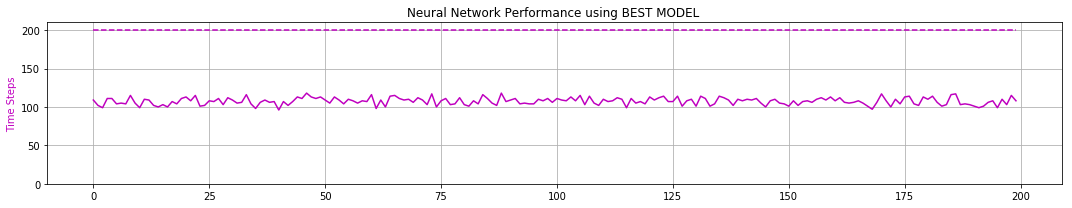

peak memory: 1418.64 MiB, increment: 1017.95 MiB
0 -max- [ 0.187  1.203  0.048  1.212]
0 -min- [-2.395 -3.089 -0.209 -1.679]

1 -max- [ 0.152  1.174  0.048  1.222]
1 -min- [-2.392 -3.123 -0.209 -1.663]

2 -max- [ 0.149  1.208  0.046  1.292]
2 -min- [-2.398 -3.129 -0.209 -1.682]

3 -max- [ 0.154  1.180  0.048  1.296]
3 -min- [-2.399 -3.067 -0.209 -1.715]

4 -max- [ 0.168  1.175  0.049  1.111]
4 -min- [-2.393 -3.125 -0.209 -1.772]

5 -max- [ 0.176  1.204  0.049  1.293]
5 -min- [-2.391 -3.092 -0.209 -1.778]

6 -max- [ 0.190  1.193  0.049  1.171]
6 -min- [-2.394 -3.130 -0.209 -1.672]

7 -max- [ 0.164  1.147  0.050  1.131]
7 -min- [-2.400 -3.098 -0.209 -1.665]

8 -max- [ 0.197  1.214  0.048  0.923]
8 -min- [-2.393 -3.111 -0.209 -1.683]

9 -max- [ 0.141  1.142  0.048  1.158]
9 -min- [-2.378 -3.102 -0.209 -1.658]

Quantization TIME:  0.02 minutes


ITERATION # 6
TOTAL EXPERIENCE GENERATED:   84439
SMALLEST TIMESTEP: 22
LARGEST  TIMESTEP: 117
TOTAL SERIAL TIMESTEPS:   522570
TOTAL PARALLEL TIM

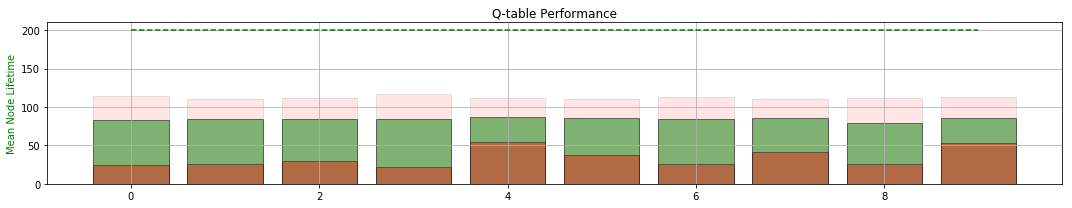

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 203.416	LOSS : 220.103	LOSS : 237.350	LOSS : 283.363	LOSS : 263.741	LOSS : 271.959	LOSS : 250.195	LOSS : 248.856	LOSS : 241.302	LOSS : 242.586	LOSS : 219.191	LOSS : 203.105	LOSS : 189.782	LOSS : 197.567	LOSS : 187.071	LOSS : 163.669	LOSS : 176.673	LOSS : 165.216	LOSS : 181.153	LOSS : 173.149	
Validating... MEAN TIME:  103.145
LOSS : 188.014	LOSS : 178.750	LOSS : 175.828	LOSS : 196.489	LOSS : 187.614	LOSS : 201.688	LOSS : 189.917	LOSS : 190.654	LOSS : 201.527	LOSS : 186.956	LOSS : 188.615	LOSS : 194.522	LOSS : 200.506	LOSS : 208.184	LOSS : 206.588	LOSS : 231.240	LOSS : 215.287	LOSS : 177.550	LOSS : 207.706	LOSS : 199.201	
Validating... MEAN TIME:  9.355
LOSS : 201.301	LOSS : 193.665	LOSS : 180.465	LOSS : 207.003	LOSS : 216.969	LOSS : 192.745	LOSS : 199.753	LOSS : 182.734	LOSS : 204.499	LOSS : 179.966	LOSS : 185.764	LOSS : 166.478	LOSS : 174.006	LOSS : 168.640	LOSS : 189.923	LOSS : 192.312	LOSS : 20

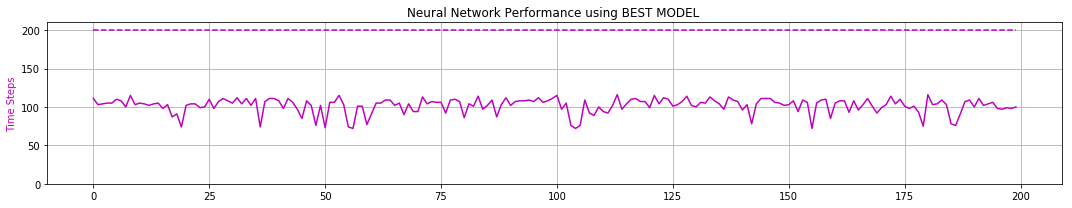

peak memory: 1378.60 MiB, increment: 1035.05 MiB
0 -max- [ 0.180  0.955  0.075  1.887]
0 -min- [-2.400 -3.301 -0.209 -1.694]

1 -max- [ 0.173  0.980  0.084  1.823]
1 -min- [-2.400 -3.300 -0.209 -1.756]

2 -max- [ 0.166  0.823  0.067  1.888]
2 -min- [-2.399 -3.279 -0.209 -1.658]

3 -max- [ 0.177  0.829  0.054  1.811]
3 -min- [-2.400 -3.266 -0.209 -1.637]

4 -max- [ 0.166  0.823  0.118  1.875]
4 -min- [-2.400 -3.322 -0.209 -1.896]

5 -max- [ 0.188  0.828  0.061  1.858]
5 -min- [-2.399 -3.284 -0.209 -1.643]

6 -max- [ 0.172  0.824  0.125  1.895]
6 -min- [-2.400 -3.294 -0.209 -1.841]

7 -max- [ 0.197  0.830  0.055  1.842]
7 -min- [-2.400 -3.300 -0.209 -1.663]

8 -max- [ 0.153  0.974  0.071  1.884]
8 -min- [-2.398 -3.317 -0.209 -1.665]

9 -max- [ 0.186  0.829  0.065  1.778]
9 -min- [-2.399 -3.255 -0.209 -1.615]

Quantization TIME:  0.02 minutes


ITERATION # 7
TOTAL EXPERIENCE GENERATED:   66910
SMALLEST TIMESTEP: 28
LARGEST  TIMESTEP: 113
TOTAL SERIAL TIMESTEPS:   589480
TOTAL PARALLEL TIM

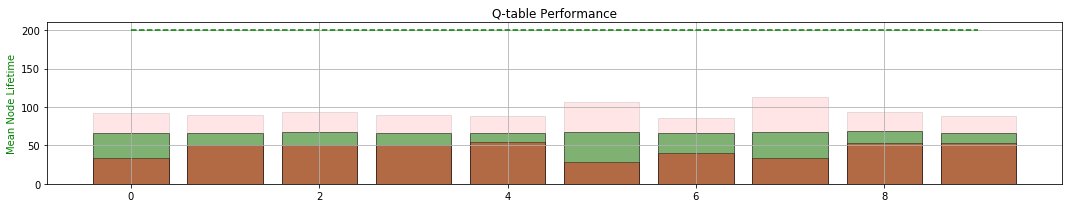

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 213.446	LOSS : 198.050	LOSS : 197.340	LOSS : 197.050	LOSS : 224.265	LOSS : 205.771	LOSS : 223.106	LOSS : 222.416	LOSS : 216.554	LOSS : 233.804	LOSS : 222.081	LOSS : 200.944	LOSS : 206.983	LOSS : 216.778	LOSS : 215.706	LOSS : 203.157	LOSS : 215.034	LOSS : 201.500	LOSS : 210.051	LOSS : 216.417	
Validating... MEAN TIME:  105.275
LOSS : 201.609	LOSS : 191.794	LOSS : 184.856	LOSS : 181.904	LOSS : 187.500	LOSS : 177.690	LOSS : 179.335	LOSS : 179.642	LOSS : 183.524	LOSS : 173.042	LOSS : 197.450	LOSS : 208.688	LOSS : 174.254	LOSS : 184.780	LOSS : 210.183	LOSS : 183.299	LOSS : 208.252	LOSS : 184.483	LOSS : 192.742	LOSS : 188.066	
Validating... MEAN TIME:  108.82
LOSS : 165.146	LOSS : 166.161	LOSS : 173.327	LOSS : 157.218	LOSS : 173.167	LOSS : 161.300	LOSS : 149.988	LOSS : 186.763	LOSS : 179.268	LOSS : 169.131	LOSS : 152.970	LOSS : 178.561	LOSS : 169.579	LOSS : 158.824	LOSS : 167.848	LOSS : 186.241	LOSS : 1

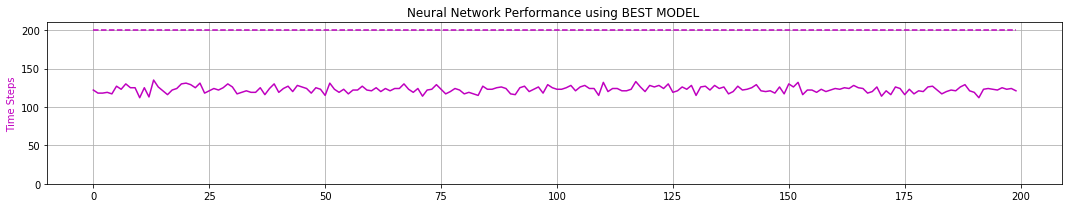

peak memory: 1420.27 MiB, increment: 1017.69 MiB
0 -max- [ 0.165  0.826  0.209  3.344]
0 -min- [-1.599 -4.014 -0.209 -1.782]

1 -max- [ 0.167  0.820  0.209  3.344]
1 -min- [-1.665 -4.015 -0.206 -1.253]

2 -max- [ 0.169  0.825  0.209  3.341]
2 -min- [-1.900 -3.965 -0.209 -1.418]

3 -max- [ 0.155  0.824  0.209  3.357]
3 -min- [-1.749 -3.960 -0.209 -1.245]

4 -max- [ 0.173  0.810  0.209  3.370]
4 -min- [-1.556 -3.941 -0.209 -1.397]

5 -max- [ 0.170  0.826  0.209  3.385]
5 -min- [-2.386 -3.987 -0.209 -1.766]

6 -max- [ 0.182  1.023  0.209  3.355]
6 -min- [-1.562 -3.967 -0.209 -1.405]

7 -max- [ 0.174  0.811  0.209  3.371]
7 -min- [-2.367 -3.957 -0.209 -1.724]

8 -max- [ 0.177  0.825  0.209  3.367]
8 -min- [-1.689 -3.798 -0.208 -1.399]

9 -max- [ 0.152  0.823  0.209  3.420]
9 -min- [-1.783 -3.994 -0.209 -1.257]

Quantization TIME:  0.01 minutes


ITERATION # 8
TOTAL EXPERIENCE GENERATED:   108784
SMALLEST TIMESTEP: 80
LARGEST  TIMESTEP: 128
TOTAL SERIAL TIMESTEPS:   698264
TOTAL PARALLEL TI

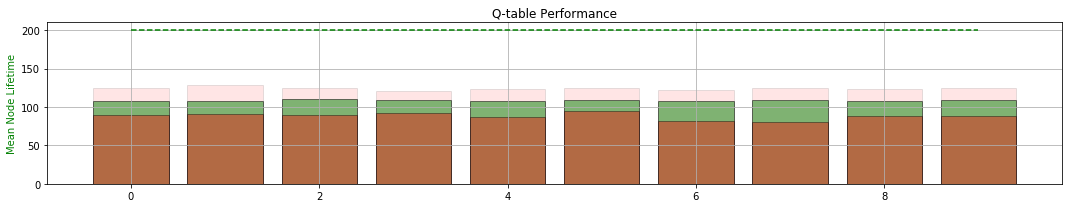

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 132.129	LOSS : 143.128	LOSS : 159.912	LOSS : 179.105	LOSS : 159.205	LOSS : 161.388	LOSS : 152.218	LOSS : 157.865	LOSS : 153.049	LOSS : 174.147	LOSS : 142.038	LOSS : 154.248	LOSS : 153.643	LOSS : 151.453	LOSS : 164.775	LOSS : 160.757	LOSS : 154.498	LOSS : 149.753	LOSS : 147.287	LOSS : 155.575	
Validating... MEAN TIME:  154.03
LOSS : 153.932	LOSS : 138.574	LOSS : 129.233	LOSS : 163.405	LOSS : 154.373	LOSS : 165.955	LOSS : 158.863	LOSS : 190.043	LOSS : 168.753	LOSS : 166.366	LOSS : 155.230	LOSS : 152.093	LOSS : 160.632	LOSS : 152.734	LOSS : 135.043	LOSS : 143.199	LOSS : 157.431	LOSS : 140.314	LOSS : 155.214	LOSS : 149.793	
Validating... MEAN TIME:  106.045
LOSS : 152.599	LOSS : 172.216	LOSS : 152.351	LOSS : 142.587	LOSS : 154.865	LOSS : 132.047	LOSS : 141.841	LOSS : 127.499	LOSS : 125.065	LOSS : 141.985	LOSS : 153.420	LOSS : 162.310	LOSS : 147.055	LOSS : 139.769	LOSS : 145.077	LOSS : 132.396	LOSS : 1

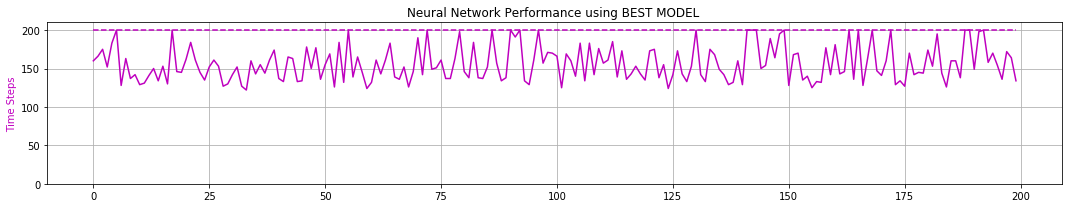

peak memory: 1376.24 MiB, increment: 1017.57 MiB
0 -max- [ 0.143  0.743  0.048  0.664]
0 -min- [-2.399 -3.115 -0.209 -1.217]

1 -max- [ 0.143  0.815  0.049  0.579]
1 -min- [-2.399 -3.130 -0.209 -1.097]

2 -max- [ 0.133  0.799  0.049  0.624]
2 -min- [-2.400 -3.154 -0.209 -1.101]

3 -max- [ 0.155  0.803  0.049  0.573]
3 -min- [-2.398 -3.166 -0.209 -1.074]

4 -max- [ 0.146  0.745  0.050  0.859]
4 -min- [-2.398 -3.117 -0.209 -1.082]

5 -max- [ 0.156  0.824  0.048  0.570]
5 -min- [-2.398 -3.123 -0.209 -1.089]

6 -max- [ 0.130  0.811  0.048  0.655]
6 -min- [-2.396 -3.114 -0.209 -1.120]

7 -max- [ 0.155  0.825  0.051  0.624]
7 -min- [-2.395 -3.120 -0.209 -1.181]

8 -max- [ 0.130  0.809  0.049  0.635]
8 -min- [-2.400 -3.148 -0.209 -1.141]

9 -max- [ 0.139  0.823  0.054  0.771]
9 -min- [-2.399 -3.137 -0.209 -1.128]

Quantization TIME:  0.01 minutes


ITERATION # 9
TOTAL EXPERIENCE GENERATED:   148001
SMALLEST TIMESTEP: 110
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   846265
TOTAL PARALLEL T

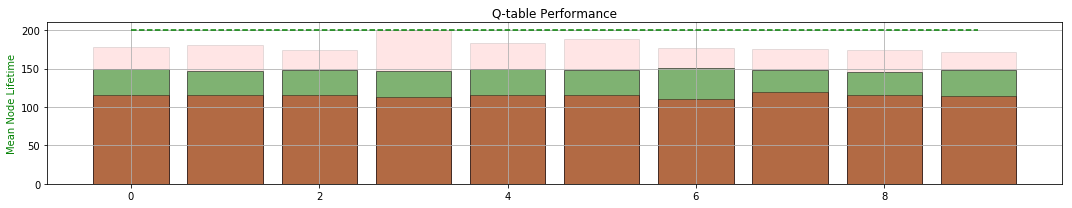

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 116.399	LOSS : 105.714	LOSS : 105.054	LOSS : 99.936	LOSS : 89.887	LOSS : 89.173	LOSS : 86.928	LOSS : 110.197	LOSS : 111.751	LOSS : 117.633	LOSS : 111.799	LOSS : 102.205	LOSS : 139.251	LOSS : 117.974	LOSS : 96.702	LOSS : 102.091	LOSS : 121.054	LOSS : 111.123	LOSS : 112.738	LOSS : 121.211	
Validating... MEAN TIME:  98.295
LOSS : 113.994	LOSS : 108.925	LOSS : 109.440	LOSS : 112.665	LOSS : 118.299	LOSS : 109.278	LOSS : 96.208	LOSS : 99.587	LOSS : 121.350	LOSS : 106.177	LOSS : 97.326	LOSS : 90.961	LOSS : 106.979	LOSS : 102.287	LOSS : 106.016	LOSS : 103.931	LOSS : 120.563	LOSS : 119.070	LOSS : 135.149	LOSS : 105.770	
Validating... MEAN TIME:  94.93
LOSS : 106.921	LOSS : 78.769	LOSS : 91.413	LOSS : 113.278	LOSS : 99.138	LOSS : 111.534	LOSS : 92.341	LOSS : 104.302	LOSS : 97.057	LOSS : 108.505	LOSS : 96.721	LOSS : 108.263	LOSS : 85.978	LOSS : 112.005	LOSS : 77.718	LOSS : 95.219	LOSS : 89.353	LOSS : 102.999

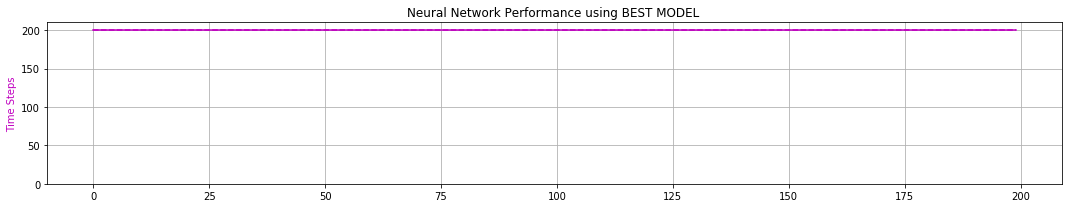

peak memory: 1439.80 MiB, increment: 1024.46 MiB
0 -max- [ 0.156  0.774  0.049  0.779]
0 -min- [-2.399 -3.097 -0.208 -1.133]

1 -max- [ 0.138  0.609  0.049  0.674]
1 -min- [-2.400 -2.955 -0.209 -0.920]

2 -max- [ 0.154  0.809  0.049  0.689]
2 -min- [-2.400 -3.081 -0.208 -1.097]

3 -max- [ 0.178  0.740  0.052  0.908]
3 -min- [-2.400 -2.958 -0.209 -1.094]

4 -max- [ 0.173  0.579  0.048  0.666]
4 -min- [-2.400 -2.938 -0.208 -0.998]

5 -max- [ 0.122  0.596  0.048  0.796]
5 -min- [-2.399 -3.063 -0.209 -0.975]

6 -max- [ 0.143  0.823  0.051  0.616]
6 -min- [-2.400 -3.062 -0.208 -1.088]

7 -max- [ 0.134  0.577  0.056  0.687]
7 -min- [-2.400 -2.937 -0.209 -0.906]

8 -max- [ 0.135  0.575  0.050  0.783]
8 -min- [-2.400 -2.931 -0.209 -0.887]

9 -max- [ 0.143  0.816  0.050  0.687]
9 -min- [-2.399 -3.064 -0.208 -1.105]

Quantization TIME:  0.01 minutes


ITERATION # 10
TOTAL EXPERIENCE GENERATED:   162949
SMALLEST TIMESTEP: 134
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1009214
TOTAL PARALLEL

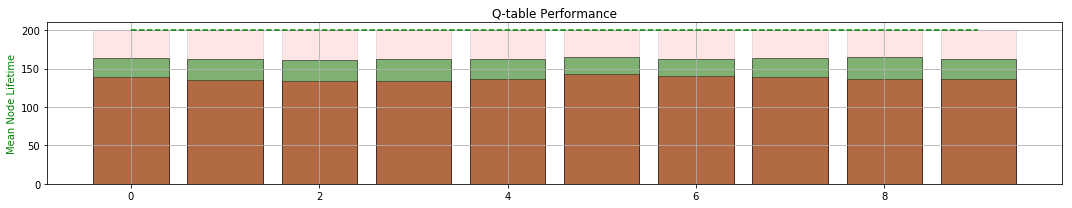

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 79.751	LOSS : 79.638	LOSS : 83.769	LOSS : 86.479	LOSS : 88.164	LOSS : 105.484	LOSS : 104.677	LOSS : 105.941	LOSS : 100.967	LOSS : 102.916	LOSS : 85.647	LOSS : 85.790	LOSS : 95.883	LOSS : 91.379	LOSS : 95.835	LOSS : 97.244	LOSS : 82.581	LOSS : 94.120	LOSS : 103.362	LOSS : 136.671	
Validating... MEAN TIME:  129.6
LOSS : 123.814	LOSS : 144.100	LOSS : 136.293	LOSS : 129.026	LOSS : 136.201	LOSS : 127.713	LOSS : 98.872	LOSS : 90.708	LOSS : 110.051	LOSS : 115.682	LOSS : 105.989	LOSS : 110.167	LOSS : 120.670	LOSS : 112.296	LOSS : 129.847	LOSS : 128.124	LOSS : 137.834	LOSS : 116.092	LOSS : 107.105	LOSS : 129.624	
Validating... MEAN TIME:  104.355
LOSS : 114.048	LOSS : 102.382	LOSS : 115.943	LOSS : 105.745	LOSS : 105.719	LOSS : 110.894	LOSS : 100.136	LOSS : 110.652	LOSS : 105.406	LOSS : 107.943	LOSS : 96.265	LOSS : 116.282	LOSS : 117.758	LOSS : 118.125	LOSS : 139.040	LOSS : 117.169	LOSS : 109.671	LOSS : 113

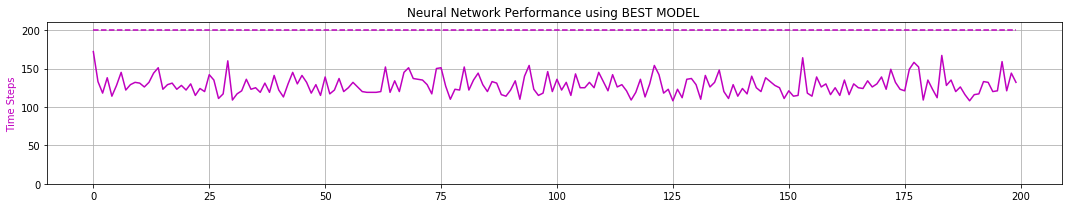

peak memory: 1479.72 MiB, increment: 997.79 MiB
0 -max- [ 0.203  0.615  0.049  0.953]
0 -min- [-2.400 -2.728 -0.209 -1.104]

1 -max- [ 0.178  0.605  0.057  0.697]
1 -min- [-2.399 -2.604 -0.209 -0.801]

2 -max- [ 0.146  0.627  0.050  0.715]
2 -min- [-2.399 -2.600 -0.209 -0.817]

3 -max- [ 0.193  0.628  0.048  0.686]
3 -min- [-2.399 -2.610 -0.209 -1.043]

4 -max- [ 0.145  0.438  0.048  0.708]
4 -min- [-2.396 -2.765 -0.209 -1.104]

5 -max- [ 0.188  0.585  0.051  0.706]
5 -min- [-2.399 -2.733 -0.209 -0.809]

6 -max- [ 0.138  0.626  0.049  0.698]
6 -min- [-2.400 -2.620 -0.209 -0.908]

7 -max- [ 0.188  0.435  0.050  0.685]
7 -min- [-2.399 -2.607 -0.209 -0.964]

8 -max- [ 0.168  0.440  0.050  0.702]
8 -min- [-2.399 -2.602 -0.209 -0.805]

9 -max- [ 0.205  0.582  0.049  0.696]
9 -min- [-2.398 -2.609 -0.209 -1.048]

Quantization TIME:  0.01 minutes


ITERATION # 11
TOTAL EXPERIENCE GENERATED:   98132
SMALLEST TIMESTEP: 11
LARGEST  TIMESTEP: 138
TOTAL SERIAL TIMESTEPS:   1107346
TOTAL PARALLEL TI

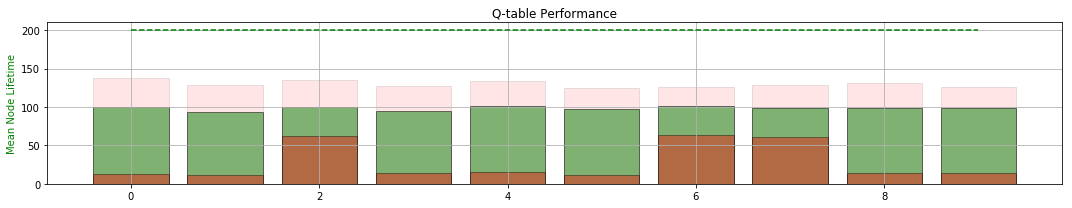

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 389.086	LOSS : 311.223	LOSS : 270.880	LOSS : 235.582	LOSS : 162.917	LOSS : 207.933	LOSS : 152.144	LOSS : 189.614	LOSS : 142.849	LOSS : 165.365	LOSS : 152.153	LOSS : 151.453	LOSS : 170.871	LOSS : 175.737	LOSS : 160.290	LOSS : 167.209	LOSS : 161.305	LOSS : 155.988	LOSS : 161.391	LOSS : 149.646	
Validating... MEAN TIME:  121.01
LOSS : 161.193	LOSS : 140.416	LOSS : 151.613	LOSS : 146.285	LOSS : 164.518	LOSS : 132.506	LOSS : 140.249	LOSS : 149.542	LOSS : 133.484	LOSS : 166.175	LOSS : 161.663	LOSS : 184.893	LOSS : 147.310	LOSS : 150.268	LOSS : 159.479	LOSS : 176.899	LOSS : 158.541	LOSS : 140.844	LOSS : 174.291	LOSS : 148.949	
Validating... MEAN TIME:  123.74
LOSS : 180.599	LOSS : 173.995	LOSS : 131.557	LOSS : 152.425	LOSS : 175.324	LOSS : 161.272	LOSS : 136.734	LOSS : 174.163	LOSS : 141.088	LOSS : 135.768	LOSS : 140.148	LOSS : 156.848	LOSS : 126.978	LOSS : 141.268	LOSS : 118.619	LOSS : 153.960	LOSS : 12

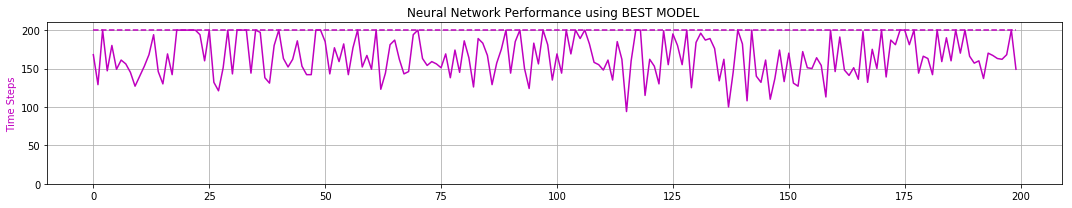

peak memory: 1460.31 MiB, increment: 997.55 MiB
0 -max- [ 0.155  0.828  0.049  1.189]
0 -min- [-2.399 -3.079 -0.209 -1.348]

1 -max- [ 0.148  0.940  0.050  1.207]
1 -min- [-2.399 -3.062 -0.209 -1.364]

2 -max- [ 0.160  0.824  0.048  1.055]
2 -min- [-2.398 -3.089 -0.209 -1.194]

3 -max- [ 0.132  0.989  0.048  1.179]
3 -min- [-2.400 -3.118 -0.209 -1.426]

4 -max- [ 0.157  0.991  0.051  1.185]
4 -min- [-2.396 -3.094 -0.209 -1.396]

5 -max- [ 0.131  0.829  0.049  1.229]
5 -min- [-2.399 -3.090 -0.209 -1.389]

6 -max- [ 0.136  0.950  0.050  1.224]
6 -min- [-2.399 -3.093 -0.209 -1.363]

7 -max- [ 0.154  0.980  0.054  1.137]
7 -min- [-2.399 -2.971 -0.209 -1.356]

8 -max- [ 0.133  0.933  0.049  1.215]
8 -min- [-2.400 -2.972 -0.209 -1.441]

9 -max- [ 0.123  1.009  0.050  1.193]
9 -min- [-2.399 -3.087 -0.209 -1.471]

Quantization TIME:  0.01 minutes


ITERATION # 12
TOTAL EXPERIENCE GENERATED:   128068
SMALLEST TIMESTEP: 71
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1235414
TOTAL PARALLEL T

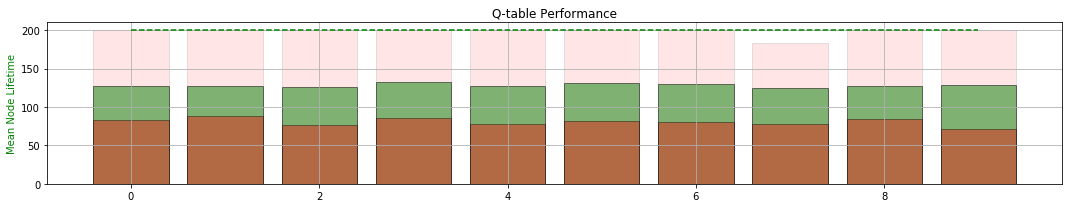

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 115.142	LOSS : 128.983	LOSS : 87.600	LOSS : 110.185	LOSS : 106.102	LOSS : 111.438	LOSS : 123.327	LOSS : 106.798	LOSS : 123.773	LOSS : 108.506	LOSS : 133.619	LOSS : 132.360	LOSS : 130.261	LOSS : 129.549	LOSS : 138.289	LOSS : 140.694	LOSS : 132.497	LOSS : 133.782	LOSS : 170.406	LOSS : 125.426	
Validating... MEAN TIME:  150.92
LOSS : 133.488	LOSS : 123.155	LOSS : 124.240	LOSS : 99.838	LOSS : 129.893	LOSS : 113.578	LOSS : 119.074	LOSS : 112.221	LOSS : 129.593	LOSS : 143.416	LOSS : 156.397	LOSS : 148.754	LOSS : 135.596	LOSS : 129.260	LOSS : 145.972	LOSS : 125.089	LOSS : 126.077	LOSS : 150.545	LOSS : 126.524	LOSS : 142.377	
Validating... MEAN TIME:  138.18
LOSS : 123.806	LOSS : 150.519	LOSS : 127.847	LOSS : 135.051	LOSS : 148.814	LOSS : 160.254	LOSS : 147.762	LOSS : 131.004	LOSS : 119.145	LOSS : 127.721	LOSS : 123.138	LOSS : 119.915	LOSS : 156.510	LOSS : 147.080	LOSS : 180.973	LOSS : 145.568	LOSS : 153.

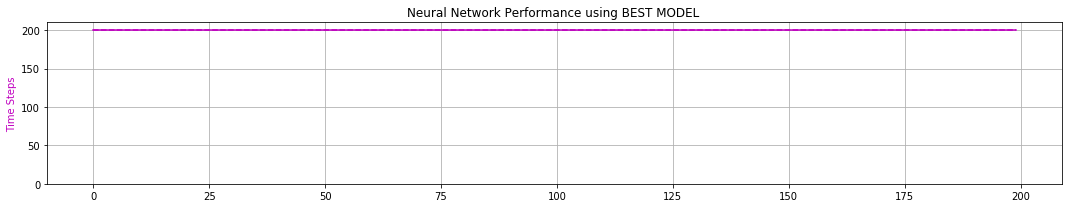

peak memory: 1499.38 MiB, increment: 978.02 MiB
0 -max- [ 0.786  1.323  0.209  1.038]
0 -min- [-2.393 -3.159 -0.209 -1.104]

1 -max- [ 0.782  1.321  0.209  0.841]
1 -min- [-2.394 -3.282 -0.209 -1.148]

2 -max- [ 0.790  1.286  0.208  0.779]
2 -min- [-2.389 -3.138 -0.209 -1.071]

3 -max- [ 0.772  1.300  0.209  0.908]
3 -min- [-2.398 -3.162 -0.209 -1.103]

4 -max- [ 0.809  1.471  0.208  0.955]
4 -min- [-2.397 -3.164 -0.209 -1.013]

5 -max- [ 0.782  1.259  0.209  0.791]
5 -min- [-2.390 -3.157 -0.209 -1.109]

6 -max- [ 0.786  1.299  0.209  0.787]
6 -min- [-2.391 -3.160 -0.209 -1.073]

7 -max- [ 0.742  1.139  0.208  0.780]
7 -min- [-2.397 -3.168 -0.209 -1.002]

8 -max- [ 0.846  1.513  0.207  1.000]
8 -min- [-2.400 -3.257 -0.209 -1.081]

9 -max- [ 0.773  1.274  0.209  0.769]
9 -min- [-2.394 -3.159 -0.209 -1.048]

Quantization TIME:  0.02 minutes


ITERATION # 13
TOTAL EXPERIENCE GENERATED:   130852
SMALLEST TIMESTEP: 99
LARGEST  TIMESTEP: 162
TOTAL SERIAL TIMESTEPS:   1366266
TOTAL PARALLEL T

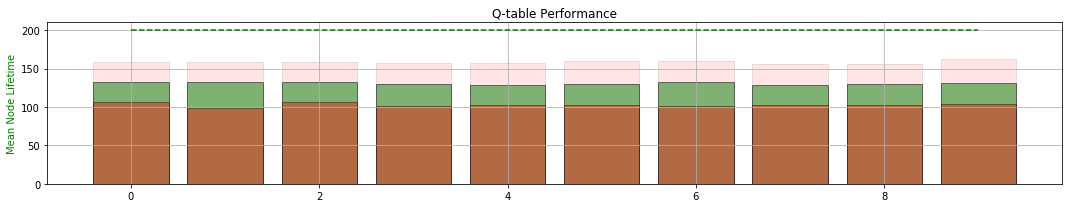

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 269.427	LOSS : 299.574	LOSS : 237.834	LOSS : 230.179	LOSS : 226.038	LOSS : 218.323	LOSS : 174.239	LOSS : 163.506	LOSS : 141.831	LOSS : 112.209	LOSS : 96.988	LOSS : 79.082	LOSS : 77.434	LOSS : 82.056	LOSS : 80.553	LOSS : 81.140	LOSS : 82.664	LOSS : 86.372	LOSS : 78.908	LOSS : 76.699	
Validating... MEAN TIME:  163.115
LOSS : 74.658	LOSS : 76.941	LOSS : 96.790	LOSS : 94.932	LOSS : 123.304	LOSS : 117.919	LOSS : 118.725	LOSS : 125.327	LOSS : 118.096	LOSS : 119.126	LOSS : 124.844	LOSS : 111.713	LOSS : 106.225	LOSS : 126.339	LOSS : 122.273	LOSS : 109.086	LOSS : 113.803	LOSS : 130.061	LOSS : 132.693	LOSS : 148.253	
Validating... MEAN TIME:  71.22
LOSS : 114.217	LOSS : 105.809	LOSS : 114.952	LOSS : 124.826	LOSS : 119.582	LOSS : 125.233	LOSS : 134.753	LOSS : 112.604	LOSS : 121.770	LOSS : 129.163	LOSS : 138.235	LOSS : 128.599	LOSS : 145.651	LOSS : 127.212	LOSS : 109.724	LOSS : 144.162	LOSS : 139.146	LOSS : 1

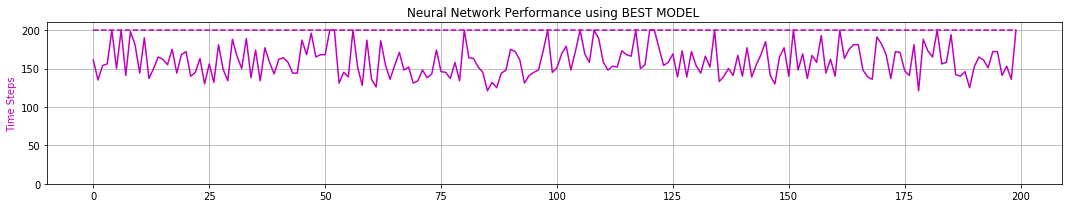

peak memory: 1466.60 MiB, increment: 1003.55 MiB
0 -max- [ 0.156  0.830  0.048  0.873]
0 -min- [-1.962 -2.000 -0.209 -1.556]

1 -max- [ 0.122  0.811  0.048  0.830]
1 -min- [-2.202 -2.333 -0.209 -1.360]

2 -max- [ 0.149  0.825  0.051  1.037]
2 -min- [-2.391 -2.598 -0.209 -1.365]

3 -max- [ 0.121  0.823  0.067  1.070]
3 -min- [-1.915 -1.998 -0.209 -1.651]

4 -max- [ 0.129  0.825  0.050  1.033]
4 -min- [-2.368 -2.721 -0.209 -1.391]

5 -max- [ 0.146  0.821  0.050  0.845]
5 -min- [-1.916 -2.007 -0.209 -1.364]

6 -max- [ 0.128  0.811  0.056  1.020]
6 -min- [-1.909 -2.007 -0.209 -1.376]

7 -max- [ 0.114  0.824  0.050  0.821]
7 -min- [-1.969 -2.170 -0.209 -1.607]

8 -max- [ 0.130  0.821  0.050  1.016]
8 -min- [-1.890 -1.884 -0.209 -1.365]

9 -max- [ 0.122  0.826  0.050  0.854]
9 -min- [-1.928 -1.973 -0.209 -1.382]

Quantization TIME:  0.01 minutes


ITERATION # 14
TOTAL EXPERIENCE GENERATED:   115670
SMALLEST TIMESTEP: 45
LARGEST  TIMESTEP: 186
TOTAL SERIAL TIMESTEPS:   1481936
TOTAL PARALLEL 

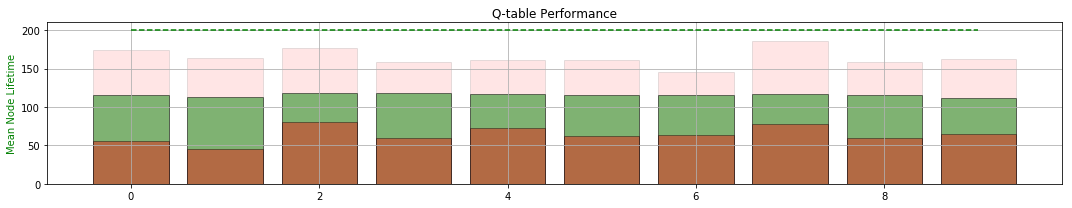

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 276.697	LOSS : 232.710	LOSS : 205.796	LOSS : 176.826	LOSS : 184.645	LOSS : 149.743	LOSS : 166.125	LOSS : 149.277	LOSS : 125.308	LOSS : 176.078	LOSS : 151.358	LOSS : 171.763	LOSS : 137.565	LOSS : 173.467	LOSS : 138.598	LOSS : 160.632	LOSS : 133.085	LOSS : 136.547	LOSS : 146.471	LOSS : 131.012	
Validating... MEAN TIME:  200.0
LOSS : 131.815	LOSS : 152.620	LOSS : 135.547	LOSS : 137.110	LOSS : 120.828	LOSS : 109.148	LOSS : 123.778	LOSS : 146.038	LOSS : 148.710	LOSS : 129.204	LOSS : 164.145	LOSS : 125.804	LOSS : 140.950	LOSS : 141.047	LOSS : 145.768	LOSS : 105.372	LOSS : 128.588	LOSS : 128.299	LOSS : 114.434	LOSS : 136.226	
Validating... MEAN TIME:  182.305
LOSS : 121.662	LOSS : 127.304	LOSS : 137.076	LOSS : 113.231	LOSS : 112.963	LOSS : 122.538	LOSS : 121.649	LOSS : 120.161	LOSS : 133.469	LOSS : 123.312	LOSS : 141.058	LOSS : 150.187	LOSS : 128.921	LOSS : 117.565	LOSS : 100.107	LOSS : 131.931	LOSS : 12

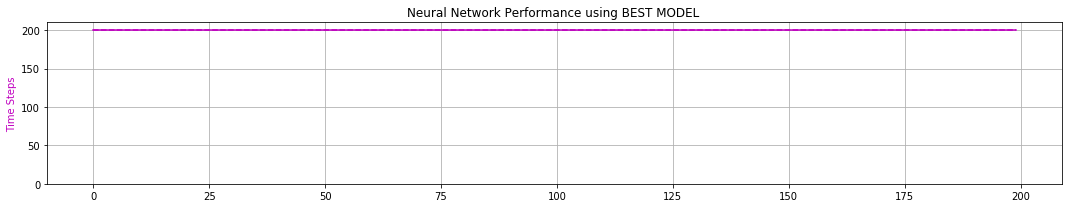

peak memory: 1472.80 MiB, increment: 977.78 MiB
0 -max- [ 0.202  0.573  0.048  0.902]
0 -min- [-2.400 -2.950 -0.209 -1.076]

1 -max- [ 0.225  0.575  0.051  0.926]
1 -min- [-2.399 -2.967 -0.209 -1.295]

2 -max- [ 0.227  0.435  0.049  0.919]
2 -min- [-2.400 -2.963 -0.209 -1.081]

3 -max- [ 0.198  0.578  0.050  0.929]
3 -min- [-2.399 -2.969 -0.208 -1.051]

4 -max- [ 0.222  0.576  0.050  0.976]
4 -min- [-2.400 -2.956 -0.209 -1.160]

5 -max- [ 0.197  0.612  0.049  0.903]
5 -min- [-2.400 -2.950 -0.209 -1.067]

6 -max- [ 0.209  0.605  0.050  0.861]
6 -min- [-2.399 -3.088 -0.209 -1.254]

7 -max- [ 0.193  0.554  0.050  1.124]
7 -min- [-2.400 -2.904 -0.209 -1.259]

8 -max- [ 0.180  0.569  0.050  0.721]
8 -min- [-2.399 -2.919 -0.209 -1.147]

9 -max- [ 0.198  0.435  0.048  0.966]
9 -min- [-2.400 -3.091 -0.209 -1.103]

Quantization TIME:  0.02 minutes


ITERATION # 15
TOTAL EXPERIENCE GENERATED:   117793
SMALLEST TIMESTEP: 90
LARGEST  TIMESTEP: 149
TOTAL SERIAL TIMESTEPS:   1599729
TOTAL PARALLEL T

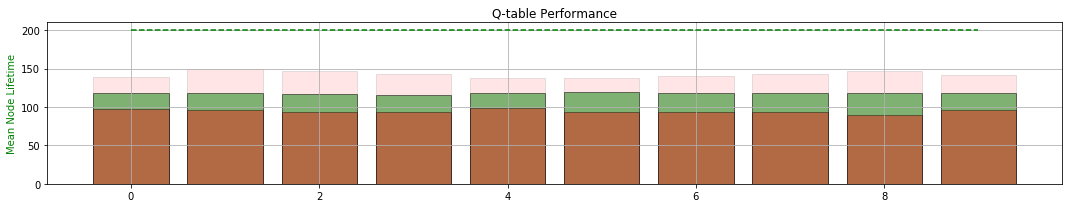

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 264.154	LOSS : 213.492	LOSS : 206.599	LOSS : 187.575	LOSS : 172.973	LOSS : 166.947	LOSS : 142.045	LOSS : 167.269	LOSS : 127.065	LOSS : 136.177	LOSS : 132.389	LOSS : 121.788	LOSS : 120.827	LOSS : 124.163	LOSS : 100.493	LOSS : 128.689	LOSS : 125.174	LOSS : 115.809	LOSS : 101.852	LOSS : 131.332	
Validating... MEAN TIME:  195.54
LOSS : 156.241	LOSS : 155.369	LOSS : 128.197	LOSS : 162.707	LOSS : 129.252	LOSS : 120.629	LOSS : 150.755	LOSS : 163.150	LOSS : 183.205	LOSS : 143.218	LOSS : 155.901	LOSS : 211.737	LOSS : 138.376	LOSS : 154.811	LOSS : 149.008	LOSS : 164.651	LOSS : 144.539	LOSS : 170.168	LOSS : 161.497	LOSS : 126.477	
Validating... MEAN TIME:  158.84
LOSS : 167.785	LOSS : 125.025	LOSS : 156.079	LOSS : 126.216	LOSS : 161.440	LOSS : 141.481	LOSS : 139.951	LOSS : 162.616	LOSS : 144.567	LOSS : 144.271	LOSS : 148.704	LOSS : 149.191	LOSS : 137.317	LOSS : 178.320	LOSS : 154.602	LOSS : 151.795	LOSS : 12

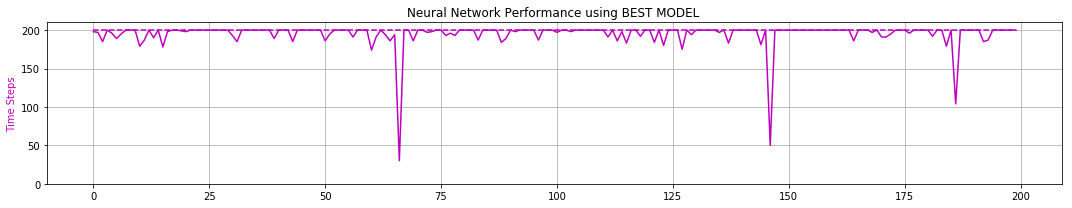

peak memory: 1438.45 MiB, increment: 982.52 MiB
0 -max- [ 1.975  2.408  0.165  1.463]
0 -min- [-0.163 -1.019 -0.209 -1.732]

1 -max- [ 1.691  2.290  0.145  1.488]
1 -min- [-0.133 -0.969 -0.209 -1.760]

2 -max- [ 1.848  2.287  0.160  1.531]
2 -min- [-0.141 -1.022 -0.209 -1.860]

3 -max- [ 1.850  2.428  0.202  1.564]
3 -min- [-0.135 -1.010 -0.209 -1.684]

4 -max- [ 1.857  2.400  0.150  1.438]
4 -min- [-0.142 -1.023 -0.209 -1.723]

5 -max- [ 1.928  2.414  0.180  1.685]
5 -min- [-0.145 -0.997 -0.209 -1.977]

6 -max- [ 1.834  2.274  0.179  1.609]
6 -min- [-0.153 -1.010 -0.209 -1.696]

7 -max- [ 1.785  2.274  0.166  1.673]
7 -min- [-0.127 -1.216 -0.209 -1.710]

8 -max- [ 1.934  2.445  0.185  1.456]
8 -min- [-0.134 -1.019 -0.209 -1.987]

9 -max- [ 1.714  2.297  0.159  1.649]
9 -min- [-0.119 -1.021 -0.209 -1.729]

Quantization TIME:  0.01 minutes


ITERATION # 16
TOTAL EXPERIENCE GENERATED:   125424
SMALLEST TIMESTEP: 10
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1725153
TOTAL PARALLEL T

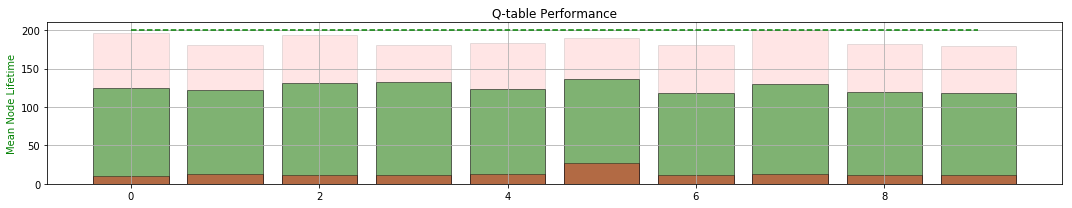

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 133.255	LOSS : 191.405	LOSS : 233.789	LOSS : 189.242	LOSS : 327.372	LOSS : 234.987	LOSS : 320.334	LOSS : 278.887	LOSS : 283.636	LOSS : 297.873	LOSS : 263.096	LOSS : 298.179	LOSS : 281.262	LOSS : 276.350	LOSS : 256.964	LOSS : 252.102	LOSS : 234.673	LOSS : 197.965	LOSS : 214.419	LOSS : 214.584	
Validating... MEAN TIME:  123.07
LOSS : 185.995	LOSS : 211.784	LOSS : 249.231	LOSS : 184.055	LOSS : 183.160	LOSS : 150.700	LOSS : 224.875	LOSS : 201.489	LOSS : 176.420	LOSS : 190.509	LOSS : 193.909	LOSS : 179.910	LOSS : 186.191	LOSS : 152.736	LOSS : 190.827	LOSS : 210.391	LOSS : 157.291	LOSS : 193.449	LOSS : 152.509	LOSS : 183.726	
Validating... MEAN TIME:  200.0
LOSS : 186.090	LOSS : 189.241	LOSS : 131.160	LOSS : 184.679	LOSS : 147.473	LOSS : 154.554	LOSS : 141.171	LOSS : 134.319	LOSS : 161.239	LOSS : 143.251	LOSS : 155.982	LOSS : 177.001	LOSS : 187.579	LOSS : 200.524	LOSS : 212.361	LOSS : 188.360	LOSS : 223

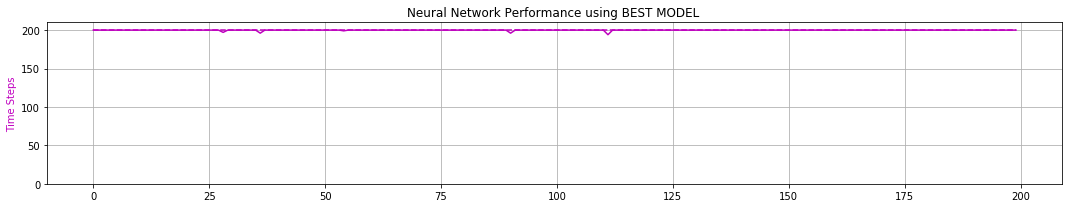

peak memory: 1477.52 MiB, increment: 978.07 MiB
0 -max- [ 0.186  1.598  0.209  2.276]
0 -min- [-2.399 -2.950 -0.209 -2.266]

1 -max- [ 0.195  1.545  0.208  2.353]
1 -min- [-2.400 -2.926 -0.209 -2.514]

2 -max- [ 0.200  1.600  0.209  2.275]
2 -min- [-2.399 -2.952 -0.209 -2.327]

3 -max- [ 0.175  1.554  0.208  2.280]
3 -min- [-2.398 -2.947 -0.209 -2.562]

4 -max- [ 0.175  1.588  0.209  2.384]
4 -min- [-2.400 -2.918 -0.209 -2.281]

5 -max- [ 0.191  1.591  0.209  2.280]
5 -min- [-2.398 -2.913 -0.209 -2.260]

6 -max- [ 0.189  1.527  0.209  2.461]
6 -min- [-2.399 -2.943 -0.209 -2.243]

7 -max- [ 0.184  1.561  0.209  2.260]
7 -min- [-2.399 -2.938 -0.209 -2.248]

8 -max- [ 0.198  1.592  0.209  2.391]
8 -min- [-2.400 -2.956 -0.209 -2.424]

9 -max- [ 0.232  1.603  0.208  2.481]
9 -min- [-2.398 -2.920 -0.209 -2.268]

Quantization TIME:  0.02 minutes


ITERATION # 17
TOTAL EXPERIENCE GENERATED:   194002
SMALLEST TIMESTEP: 86
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   1919155
TOTAL PARALLEL T

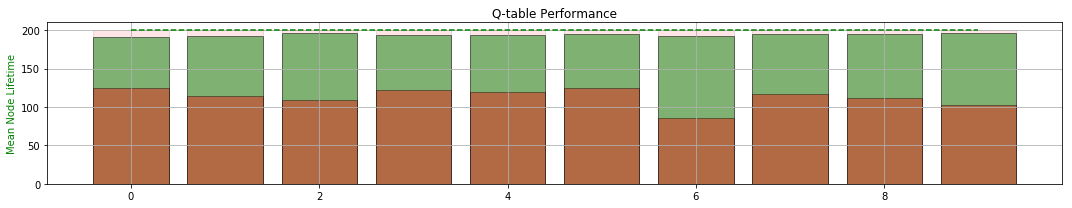

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 318.963	LOSS : 129.057	LOSS : 184.868	LOSS : 148.627	LOSS : 145.655	LOSS : 146.688	LOSS : 171.164	LOSS : 178.898	LOSS : 107.746	LOSS : 127.044	LOSS : 138.126	LOSS : 99.174	LOSS : 131.430	LOSS : 105.973	LOSS : 153.828	LOSS : 119.477	LOSS : 126.845	LOSS : 79.183	LOSS : 176.832	LOSS : 169.415	
Validating... MEAN TIME:  200.0
LOSS : 134.352	LOSS : 88.011	LOSS : 124.143	LOSS : 147.396	LOSS : 126.654	LOSS : 112.755	LOSS : 63.353	LOSS : 54.572	LOSS : 59.663	LOSS : 62.895	LOSS : 100.427	LOSS : 62.358	LOSS : 121.747	LOSS : 109.417	LOSS : 123.724	LOSS : 75.210	LOSS : 60.712	LOSS : 127.309	LOSS : 124.657	LOSS : 70.011	
Validating... MEAN TIME:  200.0
LOSS : 79.673	LOSS : 82.120	LOSS : 108.835	LOSS : 125.696	LOSS : 84.363	LOSS : 146.861	LOSS : 121.674	LOSS : 88.935	LOSS : 128.765	LOSS : 113.951	LOSS : 68.212	LOSS : 111.226	LOSS : 117.346	LOSS : 141.089	LOSS : 68.328	LOSS : 208.394	LOSS : 65.499	LOSS : 76.943	

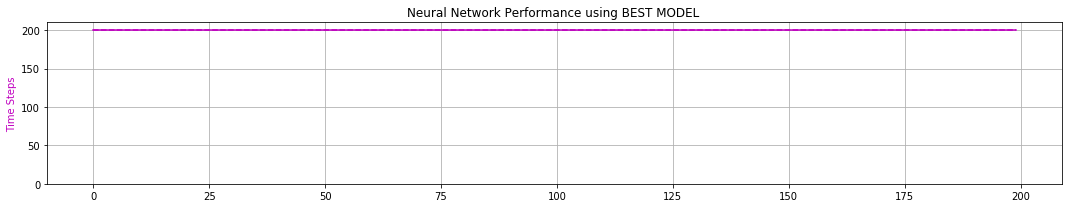

peak memory: 1497.92 MiB, increment: 1036.04 MiB
0 -max- [ 0.473  1.177  0.085  1.924]
0 -min- [-1.239 -2.648 -0.209 -2.079]

1 -max- [ 0.464  1.112  0.154  1.931]
1 -min- [-1.733 -2.813 -0.209 -1.681]

2 -max- [ 0.487  1.193  0.086  1.941]
2 -min- [-2.155 -2.766 -0.209 -1.824]

3 -max- [ 0.480  1.199  0.158  2.165]
3 -min- [-2.037 -2.695 -0.209 -1.689]

4 -max- [ 0.560  1.131  0.086  1.854]
4 -min- [-1.567 -2.652 -0.209 -1.689]

5 -max- [ 0.485  1.110  0.130  1.932]
5 -min- [-1.770 -2.826 -0.209 -1.716]

6 -max- [ 0.501  1.326  0.085  1.884]
6 -min- [-2.083 -2.770 -0.209 -1.842]

7 -max- [ 0.506  1.176  0.101  1.870]
7 -min- [-2.017 -2.816 -0.209 -1.724]

8 -max- [ 0.503  1.207  0.083  1.687]
8 -min- [-1.870 -2.639 -0.209 -1.686]

9 -max- [ 0.483  1.120  0.091  1.953]
9 -min- [-1.507 -2.659 -0.209 -1.748]

Quantization TIME:  0.02 minutes


ITERATION # 18
TOTAL EXPERIENCE GENERATED:   199396
SMALLEST TIMESTEP: 178
LARGEST  TIMESTEP: 200
TOTAL SERIAL TIMESTEPS:   2118551
TOTAL PARALLEL

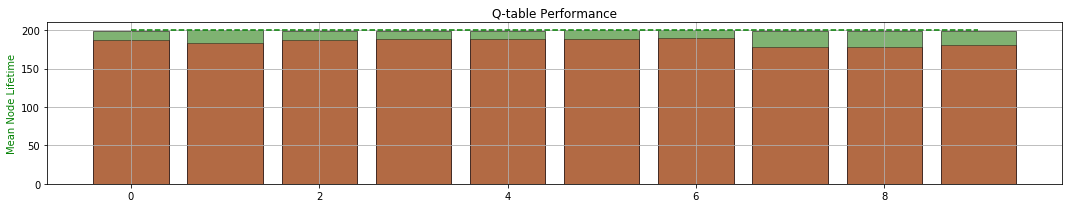

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  3013.0
Total Serial Timesteps   :  2118551.0
Speed-up                 :  703.14


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 178  18    3013    2118551     703.14
